In [67]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, random_split

In [240]:
data = yf.download(
    "SPY",
    start="1990-01-01",
    end="2021-01-01",
    auto_adjust = True,
    group_by="Ticker",
)

[*********************100%***********************]  1 of 1 completed


In [241]:
df = ta.utils.dropna(data)
df = ta.add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)

/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [271]:
def setlabel(row):
    return 1 if row['next_diff_curr'] >= 0 else 0

df['next_diff_curr'] = df['Close'].shift(-1) - df['Close']
df['label'] = df.apply(setlabel, axis=1)

df['feature_sma_diff'] = df['trend_sma_fast'] - df['trend_sma_slow']
df['feature_ema_diff'] = df['trend_ema_fast'] - df['trend_ema_slow']
df['feature_diff_bbl'] = df['Close'] - df['volatility_bbl']
df['feature_diff_bbh'] = df['volatility_bbh'] - df['Close']

In [272]:
features = [
    'trend_macd_diff',
    'volume_obv',
    'volume_fi',
    'momentum_rsi',
    'momentum_roc',
    'momentum_wr',
    'feature_sma_diff',
    'feature_ema_diff',
    'feature_diff_bbl',
    'feature_diff_bbh',
]
cols = features + ['label']

In [263]:
processed = df[cols]
processed = processed[84:]

In [264]:
class StockDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        raw = self.df.iloc[idx].values
        if type(idx) == int:
            raw = raw.reshape(1, -1)
        data = torch.tensor(raw[:, :-1], dtype=torch.float32)
        label = torch.tensor(raw[:, -1], dtype=torch.long)
        return data, label

In [265]:
chosen = processed
dataset = StockDataset(chosen)

In [266]:
train_data, valid_data = random_split(dataset, [len(dataset)*8//10, len(dataset) - len(dataset)*8//10])

In [312]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [322]:
class StockPredictor(nn.Module):

    def __init__(self, feature_size):
        super(StockPredictor, self).__init__()
        self.m1 = nn.Sequential(
            nn.Linear(feature_size, 32),
            nn.Sigmoid(),
            nn.Linear(32, 64),
            nn.Sigmoid(),
            nn.Linear(64, 128),
            nn.Sigmoid(),
            nn.Linear(128, 256),
        )
        self.m2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.m1(x)
        out = self.m2(out)
        return out

In [323]:
verbose = False

def train(model, dataloader, criterion, optimizer, epoch):
    model.train()
    train_loss, correct = 0, 0

    for batch, (data, target) in enumerate(dataloader):
        output = model(data.squeeze(1))
        loss = criterion(output, target.squeeze(1))
        train_loss += loss.item()
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate accuracy
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        
        # debug printing
        if batch % 10 == 0 and verbose:
            print('Training Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(dataloader.dataset),
                100. * batch / len(dataloader), loss.item()
            ))

    train_loss /= len(dataloader.dataset)
    total = len(dataloader.dataset) * batch_size
    accuracy = correct / total

    print(f'Epoch: {epoch}')
    print('Training set: Average loss: {:.4f}, Accuracy {}/{} ({:.0f}%)'.format(
        train_loss, correct, total, 100. * accuracy
    ))

    return (train_loss, accuracy)

def validate(dataloader, model, criterion):
    model.eval()
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data.squeeze(1))
            valid_loss += criterion(output, target.squeeze(1)).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    valid_loss /= len(dataloader.dataset)
    total = len(dataloader.dataset) * batch_size
    accuracy = correct / total

    print('Validation set: Average loss: {:.4f}, Accuracy {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, total, 100. * accuracy
    ))

    return (valid_loss, accuracy)

def run(lr, epochs=40):
    print(f'Running for epoch={epochs}, lr={lr} ... ')

    model = StockPredictor(len(features))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler = StepLR(optimizer, step_size=1, gamma=0.7, verbose=True)

    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    for t in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, t)
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)

        valid_loss, valid_accuracy = validate(valid_loader, model, criterion) 
        valid_losses.append(valid_loss)
        valid_acc.append(valid_accuracy)

#         scheduler.step()

    print('[done]')
    return (model, train_losses, valid_losses, train_acc, valid_acc)

In [326]:
model, train_losses, valid_losses, train_accs, valid_accs = run(lr=0.0001)

Running for epoch=40, lr=0.0001 ... 
Epoch: 0
Training set: Average loss: 0.0433, Accuracy 46620/88944 (52%)
Validation set: Average loss: 0.0431, Accuracy 12240/22240 (55%)

Epoch: 1
Training set: Average loss: 0.0431, Accuracy 48682/88944 (55%)
Validation set: Average loss: 0.0431, Accuracy 12242/22240 (55%)

Epoch: 2
Training set: Average loss: 0.0431, Accuracy 48691/88944 (55%)
Validation set: Average loss: 0.0431, Accuracy 12246/22240 (55%)

Epoch: 3
Training set: Average loss: 0.0431, Accuracy 48700/88944 (55%)
Validation set: Average loss: 0.0431, Accuracy 12242/22240 (55%)

Epoch: 4
Training set: Average loss: 0.0431, Accuracy 48709/88944 (55%)
Validation set: Average loss: 0.0431, Accuracy 12240/22240 (55%)

Epoch: 5
Training set: Average loss: 0.0431, Accuracy 48682/88944 (55%)
Validation set: Average loss: 0.0431, Accuracy 12240/22240 (55%)

Epoch: 6
Training set: Average loss: 0.0431, Accuracy 48700/88944 (55%)
Validation set: Average loss: 0.0431, Accuracy 12246/22240 (55%

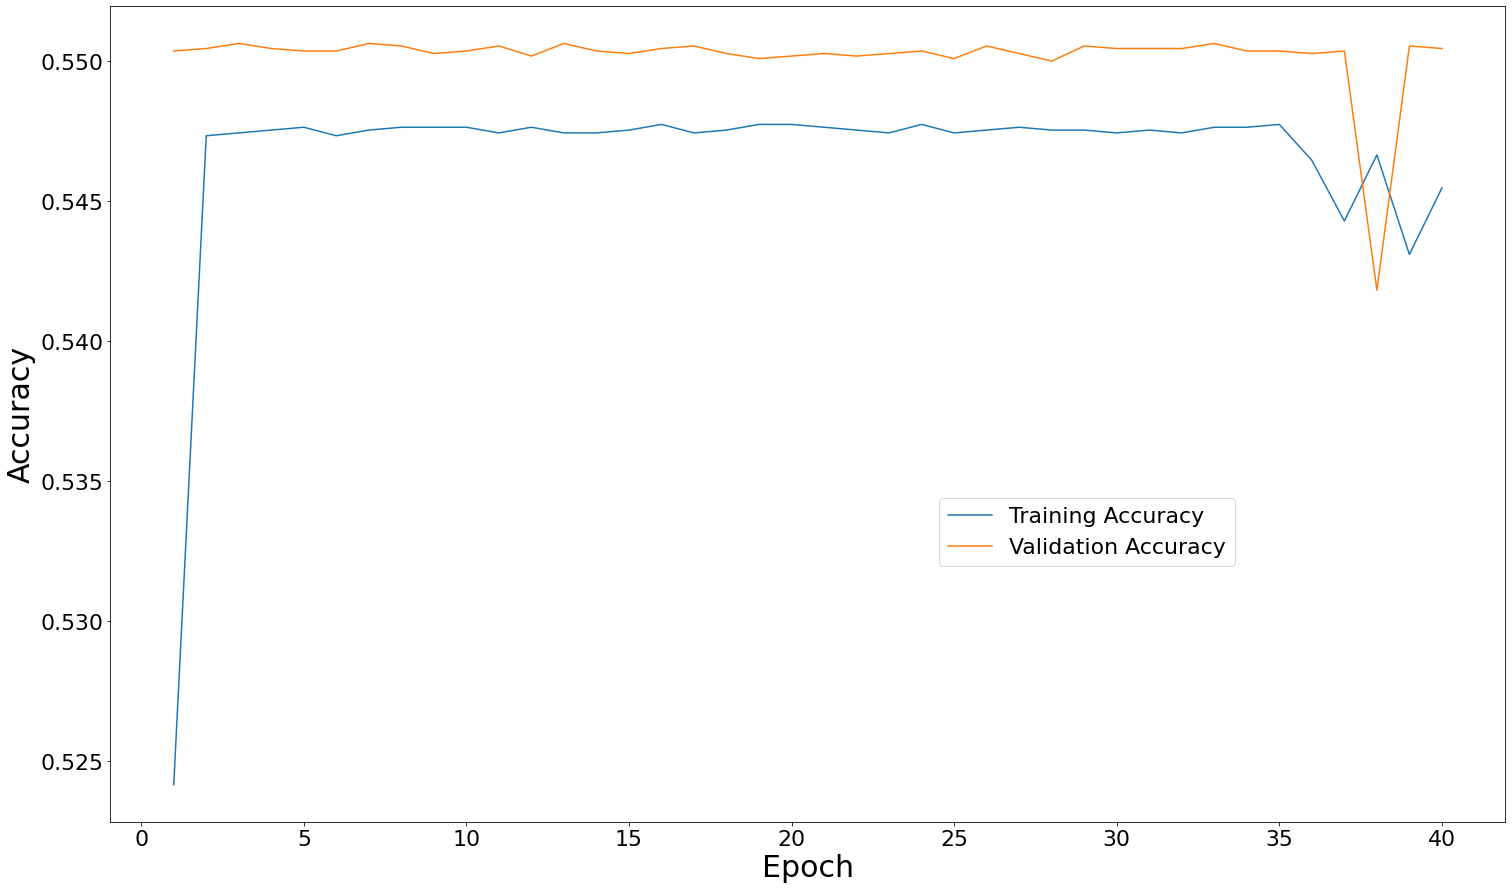

In [327]:
plt.figure(figsize=(25,15))

epoches = list(range(1,len(train_accs)+1))
plt.plot(epoches, train_accs, label='Training Accuracy')
plt.plot(epoches, valid_accs, label='Validation Accuracy')

plt.legend(loc='lower center', bbox_to_anchor=(0.7, 0.3), fontsize=22)
plt.xticks(range(0,41,5), fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Epoch', fontsize=30)
plt.ylabel('Accuracy', fontsize=30)
plt.show()

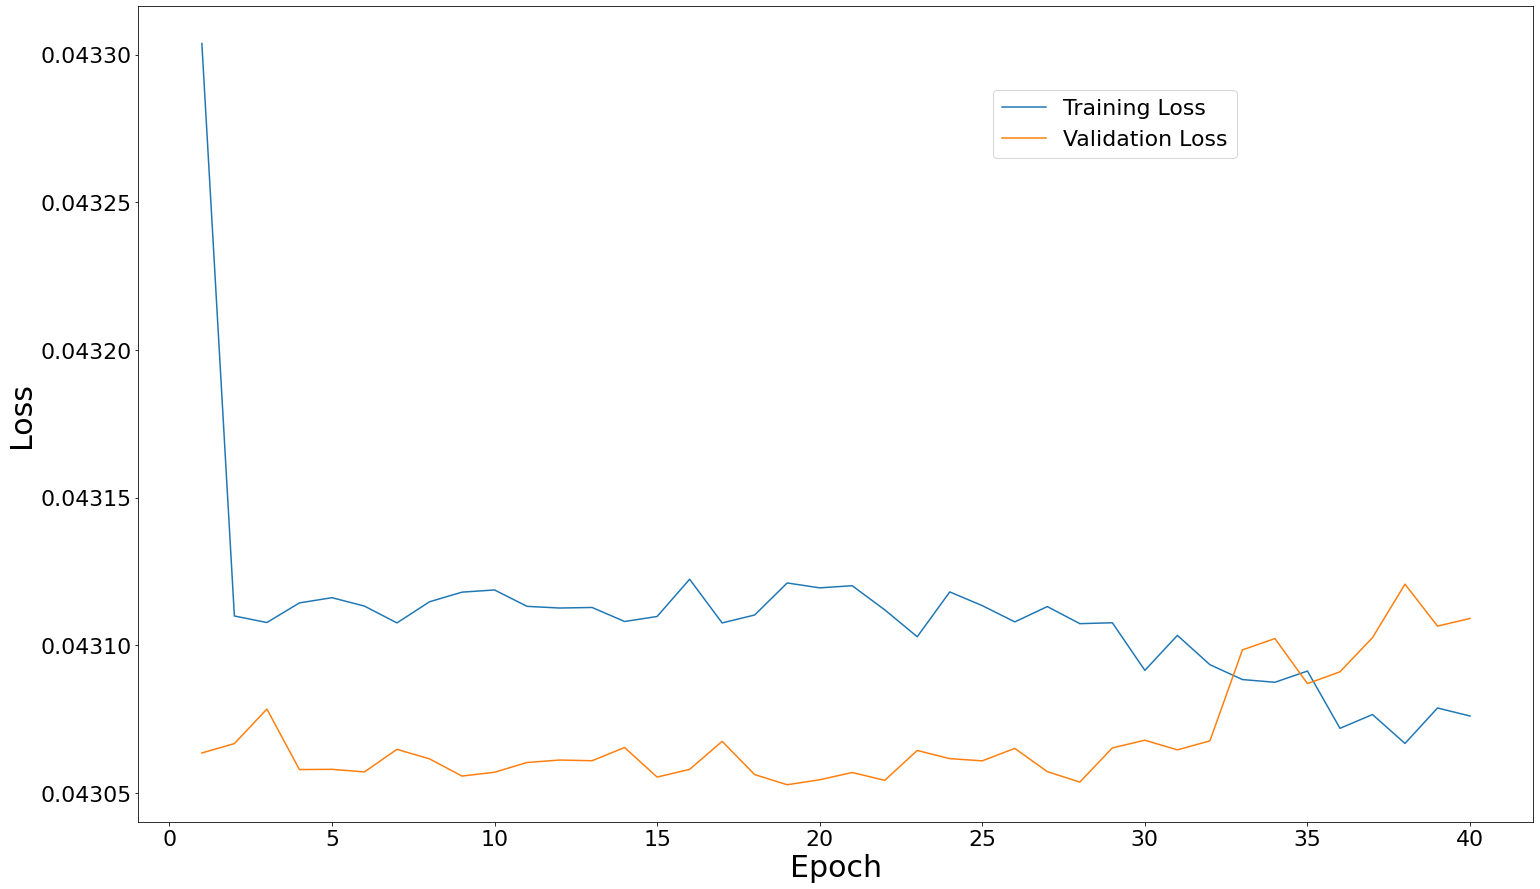

In [328]:
plt.figure(figsize=(25,15))

epoches = list(range(1,len(train_losses)+1))
plt.plot(epoches, train_losses, label='Training Loss')
plt.plot(epoches, valid_losses, label='Validation Loss')

plt.legend(loc='lower center', bbox_to_anchor=(0.7, 0.8), fontsize=22)
plt.xticks(range(0,41,5), fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Epoch', fontsize=30)
plt.ylabel('Loss', fontsize=30)
plt.show()

In [321]:
model

StockPredictor(
  (m1): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): Sigmoid()
  )
  (m2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=2, bias=True)
    (7): Softmax(dim=1)
  )
)